# L41: Lab 4 - The TCP state machine

The goals of this and the following lab are to:

- Use DTrace to investigate the actual TCP state machine and its interactions with the network stack.
- Use DTrace and DUMMYNET to investigate the effects of latency on TCP state transitions.

In this lab, we begin that investigation, which will be extended to include additional exploration of TCP bandwidth in Lab 5.

---
## Note on kernel configuration

By default, the kernel limits the maximum per-socket socket-buffer size that can be configured, in order to avoid resource starvation. You will need to tune the kernel’s default limits using the following command, run as root, prior to running benchmarks. Note that this should be set before any benchmarks are run, whether or not they are explicitly configuring the socket-buffer size, as the limit will also affect socket-buffer auto-sizing.

In [1]:
!sysctl kern.ipc.maxsockbuf=33554432

kern.ipc.maxsockbuf: 33554432 -> 33554432


---
## Running the benchmark

As before, you can run the benchmark using the ipc-static and ipc-dynamic commands, specifying vari- ous benchmark parameters. For the purposes of this benchmark, we recommend the following configuration:

- Use ipc-static.
- Use 2-thread mode.
- Do not set the socket-buffer size flag.
- Do not modify the total I/O size.

---
### IPFW and DUMMYNET

To control latency for our experimental traffic, we will employ the IPFW firewall for packet classification, and the DUMMYNET traffic-control facility to pass packets over simulated ‘pipes’. To configure two 1-way DUM- MYNET pipes, each carrying a 10ms one-way latency, run the following cell (or run the commands in the shell):

In [2]:
latency = 10

!ipfw pipe config 1 delay {str(latency)}
!ipfw pipe config 2 delay {str(latency)}

During your experiments, you will wish to change the simulated latency to other values, which can be done by reconfiguring the pipes. Do this by repeating the above two commands but with modified last parameters, which specify one-way latencies in milliseconds (e.g., replace ‘10’ with ‘5’ in both commands). The total Round-Trip Time (RTT) is the sum of the two latencies – i.e., 10ms in each direction comes to a total of 20ms RTT. Note that DUMMYNET is a simulation tool, and subject to limits on granularity and precision. Next, you must assign traffic associated with the experiment, classified by its TCP port number and presence on the loopback interface (lo0), to the pipes to inject latency:

In [3]:
!ipfw add 1 pipe 1 tcp from any 10141 to any via lo0
!ipfw add 2 pipe 2 tcp from any to any 10141 via lo0

00001 pipe 1 tcp from any 10141 to any via lo0
00002 pipe 2 tcp from any to any dst-port 10141 via lo0


### Configuring the loopback MTU

Network interfaces have a configured Maximum Transmission Unit (MTU) – the size, in bytes, of the largest packet that can be sent. For most Ethernet and Ethernet-like interfaces, the MTU is typically 1,500 bytes, although larger ‘jumbograms’ can also be used in LAN environments. The loopback interface provides a simulated network interface carrying traffic for loopback addresses such as 127.0.0.1 (localhost), and typically uses a larger (16K+) MTU. To allow our simulated results to more closely resemble LAN or WAN traffic, run the following command as root to set the loopback-interface MTU to 1,500 bytes after each boot:

In [4]:
!ifconfig lo0 mtu 1500

### Example benchmark commands

This command instructs the IPC benchmark to perform a transfer over TCP in 2-thread mode:

In [ ]:
# Example benchmark command
print_header("Creating file to run benchmark")

!ipc/ipc-static -v -i tcp 2thread
    
print_footer("Completed")

---
## Exploring the TCP state machine

The following example demonstrates:

- Tracing state transitions and
- using DTrace’s stack() function to determine which state transitions are triggered by packets received over the network (e.g., passing via tcp input() vs. those that are triggered by local system calls).

In [5]:
# Configure the one-way latency to 10ms
latency = 10

!ipfw pipe config 1 delay {str(latency)}
!ipfw pipe config 2 delay {str(latency)}

# Trace state transitions printing the receiving and sending port numbers for
# the connection experiencing the transi- tion:
tcp_state_change_script = """
fbt::tcp_state_change:entry {
    printf("{\\"timestamp\\": %u, \\"local_port\\": %u, \\"foreign_port\\": %u, \\"previous_tcp_state\\": \\"%s\\", \\"tcp_state\\": \\"%s\\"}", 
    walltimestamp,
    ntohs(args[0]->t_inpcb->inp_inc.inc_ie.ie_lport),
    ntohs(args[0]->t_inpcb->inp_inc.inc_ie.ie_fport),
    tcp_state_string[args[0]->t_state],
    tcp_state_string[args[1]]);

    stack();
}
"""

# Callback invoked to process the aggregation
values = []

def simple_out(raw_value):
    values.append(raw_value)

# Create a seperate thread to run the DTrace instrumentation
dtrace_thread = DTraceConsumerThread(tcp_state_change_script,
                                    out_func=simple_out,
                                    chew_func=lambda v: None,
                                    chewrec_func=lambda v: None,
                                    walk_func=None,
                                    sleep=1)

# Start the DTrace instrumentation
dtrace_thread.start()

# Display header to indicate that the benchmarking has started
print_header("Running ipc benchmark")

# Run the ipc-static benchmark
benchmark_output = !ipc/ipc-static -v -i tcp 2thread

# The benchmark has completed - stop the DTrace instrumentation
dtrace_thread.stop()
dtrace_thread.join()
dtrace_thread.consumer.__del__()

for raw_value in values:
    try:
        value = json.loads(raw_value)
        # JSON formatted string
        if value['previous_tcp_state'] is not None and value['tcp_state'] is not None:
            print "State transition {} -> {}".format(
                value['previous_tcp_state'], value['tcp_state'])
        else:
            print "String malformatted missing previous_tcp_state of tcp_state fields"
    except ValueError as e:
        # Raw string - manually post-process
        print "Preceeding stack frame {}".format(raw_value.split('\n')[1])
        
print_footer("Completed")

********************************************************************************
* Running ipc benchmark
********************************************************************************
State transition state-closed -> state-listen
Preceeding stack frame               kernel`sys_listen+0x88
State transition state-closed -> state-syn-sent
Preceeding stack frame               kernel`tcp_usr_connect+0x144
State transition state-syn-sent -> state-established
Preceeding stack frame               kernel`tcp_input+0xf60
State transition state-closed -> state-syn-received
Preceeding stack frame               kernel`tcp_input+0x1140
State transition state-syn-received -> state-established
Preceeding stack frame               kernel`tcp_input+0x1544
State transition state-established -> state-fin-wait-1
Preceeding stack frame               kernel`tcp_disconnect+0x5c
State transition state-established -> state-fin-wait-1
Preceeding stack frame               kernel`tcp_disconnect+0x5c
State transi

In [8]:
benchmark_output = !ipc/ipc-static -v -i tcp 2thread

---
## Graphviz

"PyGraphviz is a Python interface to the Graphviz graph layout and visualization package. With PyGraphviz you can create, edit, read, write, and draw graphs using Python to access the Graphviz graph data structure and layout algorithms."

The following example demonstrates the use of **pygraphviz** to plot a portion of the TCP finite state machine:

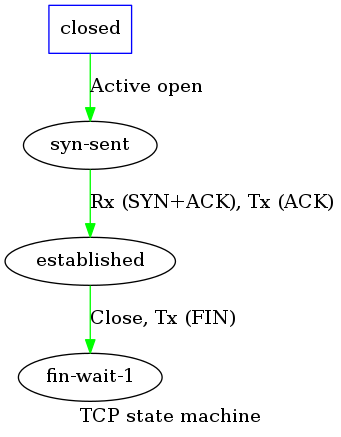

In [6]:
import pygraphviz as pgv
from IPython.display import Image

# Create the example state machine
state_machine_example = pgv.AGraph(
    label="TCP state machine", strict=False, directed=True)

state_machine_example.add_edge("closed", "syn-sent",
                label="Active open", color='green')
closed_node = state_machine_example.get_node("closed")
closed_node.attr['shape']='box'
closed_node.attr['color']='blue'
state_machine_example.add_edge(
                "syn-sent", "established",
                label="Rx (SYN+ACK), Tx (ACK)", color='green')
state_machine_example.add_edge(
               "established", "fin-wait-1",
                label="Close, Tx (FIN)", color='green')

# Draw the state machine
Image(state_machine_example.draw(format='png', prog='dot')) 

State machine diagrams can also be created from either a file or string in the *dot* format:

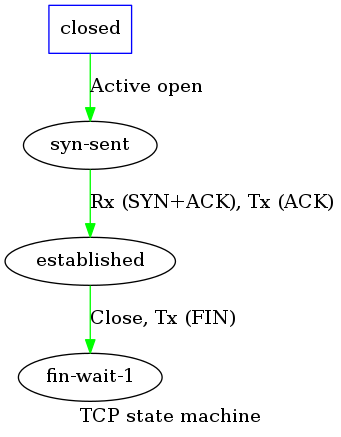

In [7]:
import pygraphviz as pgv
from IPython.display import Image

state_machine_example_spec = """digraph {
    "closed" [color=blue, shape=box];
    "closed" -> "syn-sent" [color=green, label="Active open"];
    "syn-sent" -> "established" [color=green, label="Rx (SYN+ACK), Tx (ACK)"];
    "established" -> "fin-wait-1" [color=green, label="Close, Tx (FIN)"];
}"""

state_machine_example = pgv.AGraph(state_machine_example_spec,
    label="TCP state machine", strict=False, directed=True)

# Draw the state machine
Image(state_machine_example.draw(format='png', prog='dot')) 